<a href="https://colab.research.google.com/github/pedrov718/friendly_chat_bot/blob/main/transformer_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.random.set_seed(1234)
tf.config.run_functions_eagerly(True)

#!pip install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

##Prepare Dataset

We will use the conversations in movies and TV shows provided by [Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), which contains more than 220 thousands conversational exchanges between more than 10k pairs of movie characters, as our dataset.

`movie_conversations.txt` contains list of the conversation IDs and `movie_lines.text` contains the text of assoicated with each conversation ID. For further  information regarding the dataset, please check the README file in the zip file.


In [59]:
# path_to_zip = tf.keras.utils.get_file(
#     'cornell_movie_dialogs.zip',
#     origin=
#     'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
#     extract=True)


# path_to_dataset = os.path.join(
#     os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

# path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')

# path_to_movie_conversations = os.path.join(path_to_dataset,
#                                            'movie_conversations.txt')

In [60]:
path_to_show_lines = '/content/drive/MyDrive/chatbot/data/utterances.jsonl'

path_to_show_conversations = '/content/drive/MyDrive/chatbot/data/conversations.json'

In [61]:
with open(path_to_show_lines, errors = 'ignore') as f:
    show_lines = [line for line in f]

In [62]:
with open(path_to_show_conversations, errors = 'ignore') as f:
    show_convos = [line for line in f]

In [63]:
show_convos[0]

'{"s01_e01_c01_u001": {"season": "s01", "episode": "e01", "scene": "c01"}, "s01_e01_c02_u001": {"season": "s01", "episode": "e01", "scene": "c02"}, "s01_e01_c03_u001": {"season": "s01", "episode": "e01", "scene": "c03"}, "s01_e01_c04_u001": {"season": "s01", "episode": "e01", "scene": "c04"}, "s01_e01_c05_u001": {"season": "s01", "episode": "e01", "scene": "c05"}, "s01_e01_c06_u001": {"season": "s01", "episode": "e01", "scene": "c06"}, "s01_e01_c07_u001": {"season": "s01", "episode": "e01", "scene": "c07"}, "s01_e01_c08_u001": {"season": "s01", "episode": "e01", "scene": "c08"}, "s01_e01_c09_u001": {"season": "s01", "episode": "e01", "scene": "c09"}, "s01_e01_c10_u001": {"season": "s01", "episode": "e01", "scene": "c10"}, "s01_e01_c11_u001": {"season": "s01", "episode": "e01", "scene": "c11"}, "s01_e01_c12_u001": {"season": "s01", "episode": "e01", "scene": "c12"}, "s01_e01_c13_u001": {"season": "s01", "episode": "e01", "scene": "c13"}, "s01_e01_c14_u001": {"season": "s01", "episode": 

In [64]:
show_lines[0]

'{{"id": "s01_e01_c01_u001", "conversation_id": "s01_e01_c01_u001", "text": "There\'s nothing to tell! He\'s just some guy I work with!", "speaker": "Monica Geller", "meta": {"tokens": [["There", "\'s", "nothing", "to", "tell", "!"], ["He", "\'s", "just", "some", "guy", "I", "work", "with", "!"]], "character_entities": [[], [[0, 1, "Paul the Wine Guy"], [4, 5, "Paul the Wine Guy"], [5, 6, "Monica Geller"]]], "emotion": null, "caption": null, "transcript_with_note": null, "tokens_with_note": null}, "reply-to": null, "timestamp": null}\n'

In [65]:
import re
lines = []
for line in show_lines:
  s = line
  result = re.search('"text": "(.*)", "speaker":', s)
  lines.append(result.group(1) + ' \n')
print(lines[:20])

["There's nothing to tell! He's just some guy I work with! \n", "C'mon, you're going out with the guy! There's gotta be something wrong with him! \n", 'All right Joey, be nice. So does he have a hump? A hump and a hairpiece? \n', 'Wait, does he eat chalk? \n', ' \n', "Just, 'cause, I don't want her to go through what I went through with Carl- oh! \n", "Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex. \n", 'Sounds like a date to me. \n', ' \n', "Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked. \n", 'Oh, yeah. Had that dream. \n', "Then I look down, and I realize there's a phone... there. \n", 'Instead of...? \n', "That's right. \n", 'Never had that dream. \n', 'No. \n', "All of a sudden, the phone starts to ring. Now I don't know what to do, everybody starts looking at me. \n", "And they weren't looking at you before?! \n", "Finally, I figure I'd better answer 

In [66]:
len(lines)

67373

In [67]:
# for pretty printing of cells within the Colab version of this notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### Load and preprocess data

To keep this example simple and fast, we are limiting the maximum number of training samples to`MAX_SAMPLES=25000` and the maximum length of the sentence to be `MAX_LENGTH=40`.

We preprocess our dataset in the following order:
* Extract `MAX_SAMPLES` conversation pairs into list of `questions` and `answers.
* Preprocess each sentence by removing special characters in each sentence.
* Build tokenizer (map text to ID and ID to text) using [TensorFlow Datasets SubwordTextEncoder](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder).
* Tokenize each sentence and add `START_TOKEN` and `END_TOKEN` to indicate the start and end of each sentence.
* Filter out sentence that has more than `MAX_LENGTH` tokens.
* Pad tokenized sentences to `MAX_LENGTH`



In [68]:
# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  return sentence


def load_conversations():
  # dictionary of line id to text
  # id2line = {}
  # with open(path_to_movie_lines, errors='ignore') as file:
  #   lines = file.readlines()
  # for line in lines:
  #   parts = line.replace('\n', '').split(' +++$+++ ')
  #   id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  # with open(path_to_movie_conversations, 'r') as file:
  #   lines = file.readlines()
  parts = [] 
  for line in lines:
    parts.append(line.split('\n'))
    #print(len(parts))
    # # get conversation in a list of line ID
    # conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
  for i in range(len(parts) - 1):
    inputs.append(preprocess_sentence(parts[i][0]))
    outputs.append(preprocess_sentence(parts[i + 1][0]))
    if len(inputs) >= MAX_SAMPLES:
      return inputs, outputs

  return inputs, outputs

questions, answers = load_conversations()

In [69]:
answers[:5]

['c mon , you re going out with the guy ! there s gotta be something wrong with him !',
 'all right joey , be nice . so does he have a hump ? a hump and a hairpiece ?',
 'wait , does he eat chalk ?',
 '',
 'just , cause , i don t want her to go through what i went through with carl oh !']

In [70]:
questions[:5]

['there s nothing to tell ! he s just some guy i work with !',
 'c mon , you re going out with the guy ! there s gotta be something wrong with him !',
 'all right joey , be nice . so does he have a hump ? a hump and a hairpiece ?',
 'wait , does he eat chalk ?',
 '']

In [71]:
answers[:5]

['c mon , you re going out with the guy ! there s gotta be something wrong with him !',
 'all right joey , be nice . so does he have a hump ? a hump and a hairpiece ?',
 'wait , does he eat chalk ?',
 '',
 'just , cause , i don t want her to go through what i went through with carl oh !']

In [72]:
print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))

Sample question: hi .
Sample answer: this guy says hello , i wanna kill myself .


In [73]:
# Build tokenizer using tfds for both questions and answers
#tokenizer = tfds.deprecated.text.Tokenizer()

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [74]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [98, 3]


In [75]:
# Maximum sentence length
MAX_LENGTH = 40


# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [76]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 7809
Number of samples: 45005


### Create `tf.data.Dataset`

We are going to use the [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data) to contruct our input pipline in order to utilize features like caching and prefetching to speed up the training process.

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

Target is divided into `decoder_inputs` which padded as an input to the decoder and `cropped_targets` for calculating our loss and accuracy.

In [77]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [78]:
print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


## Attention



In [79]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [80]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

## Transformer

### Masking



In [81]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [82]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [83]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [84]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Positional encoding


In [85]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

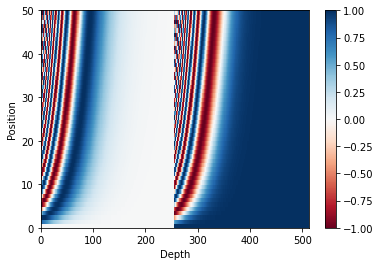

In [86]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask) 
2. 2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

In [87]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

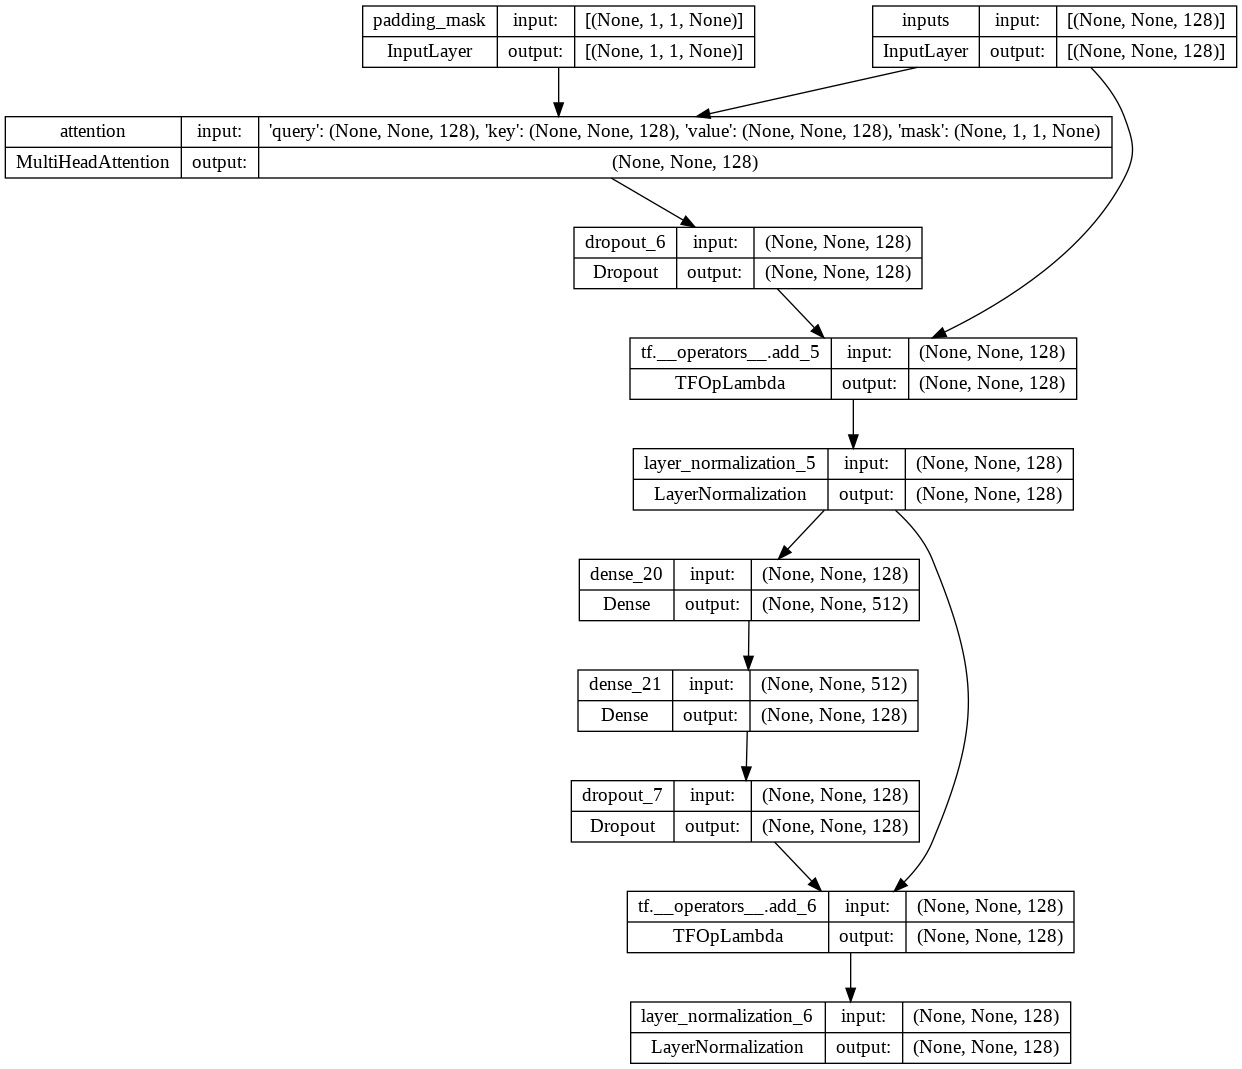

In [88]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

### Encoder



In [89]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

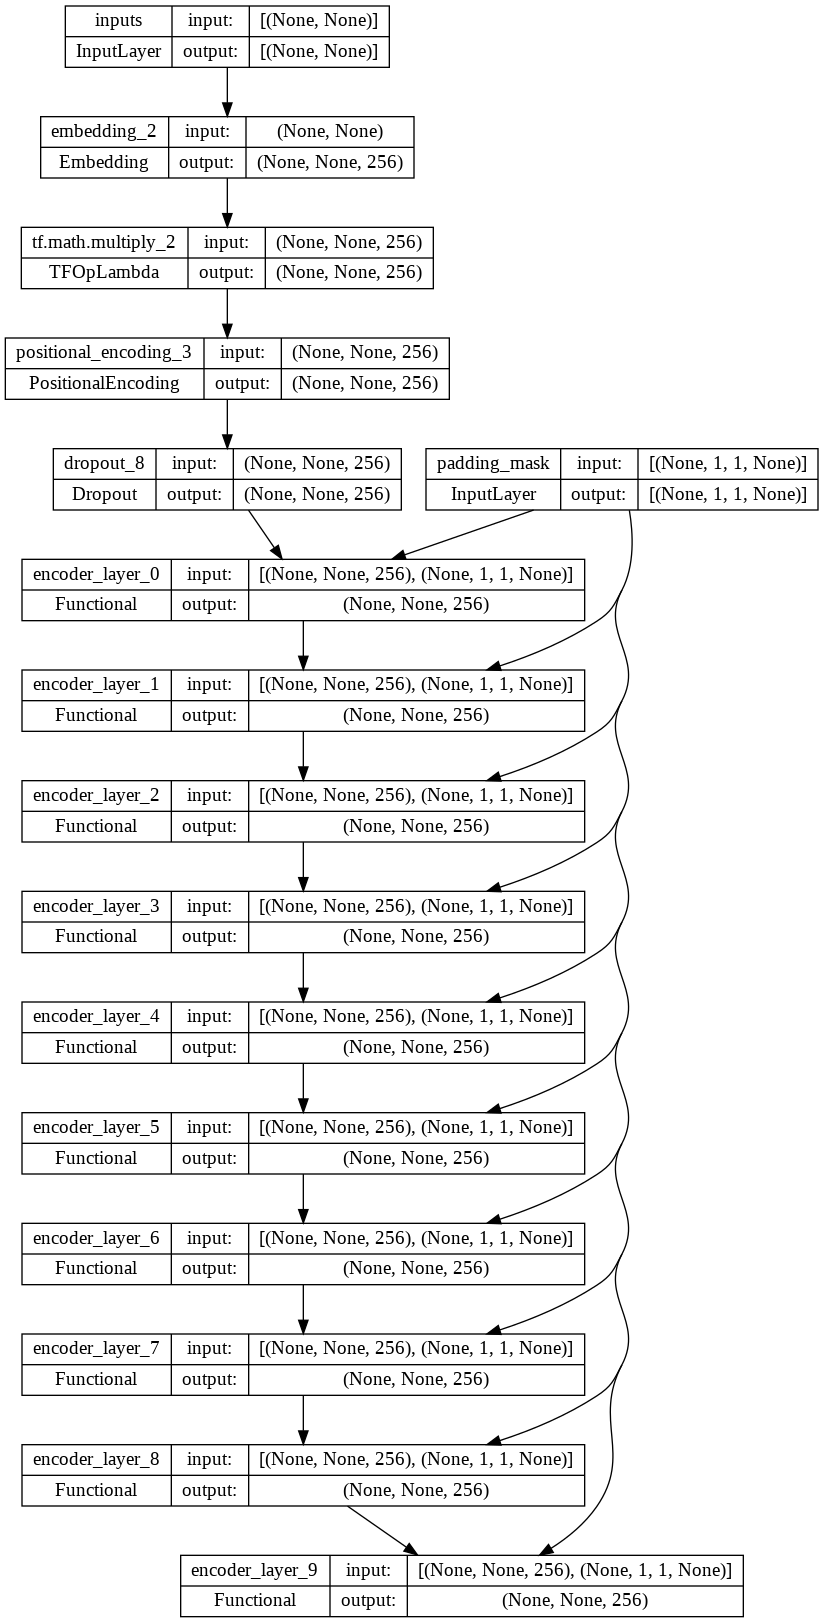

In [90]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=10,
    units=512,
    d_model=256,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

### Decoder Layer

Each decoder layer consists of sublayers:

In [91]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

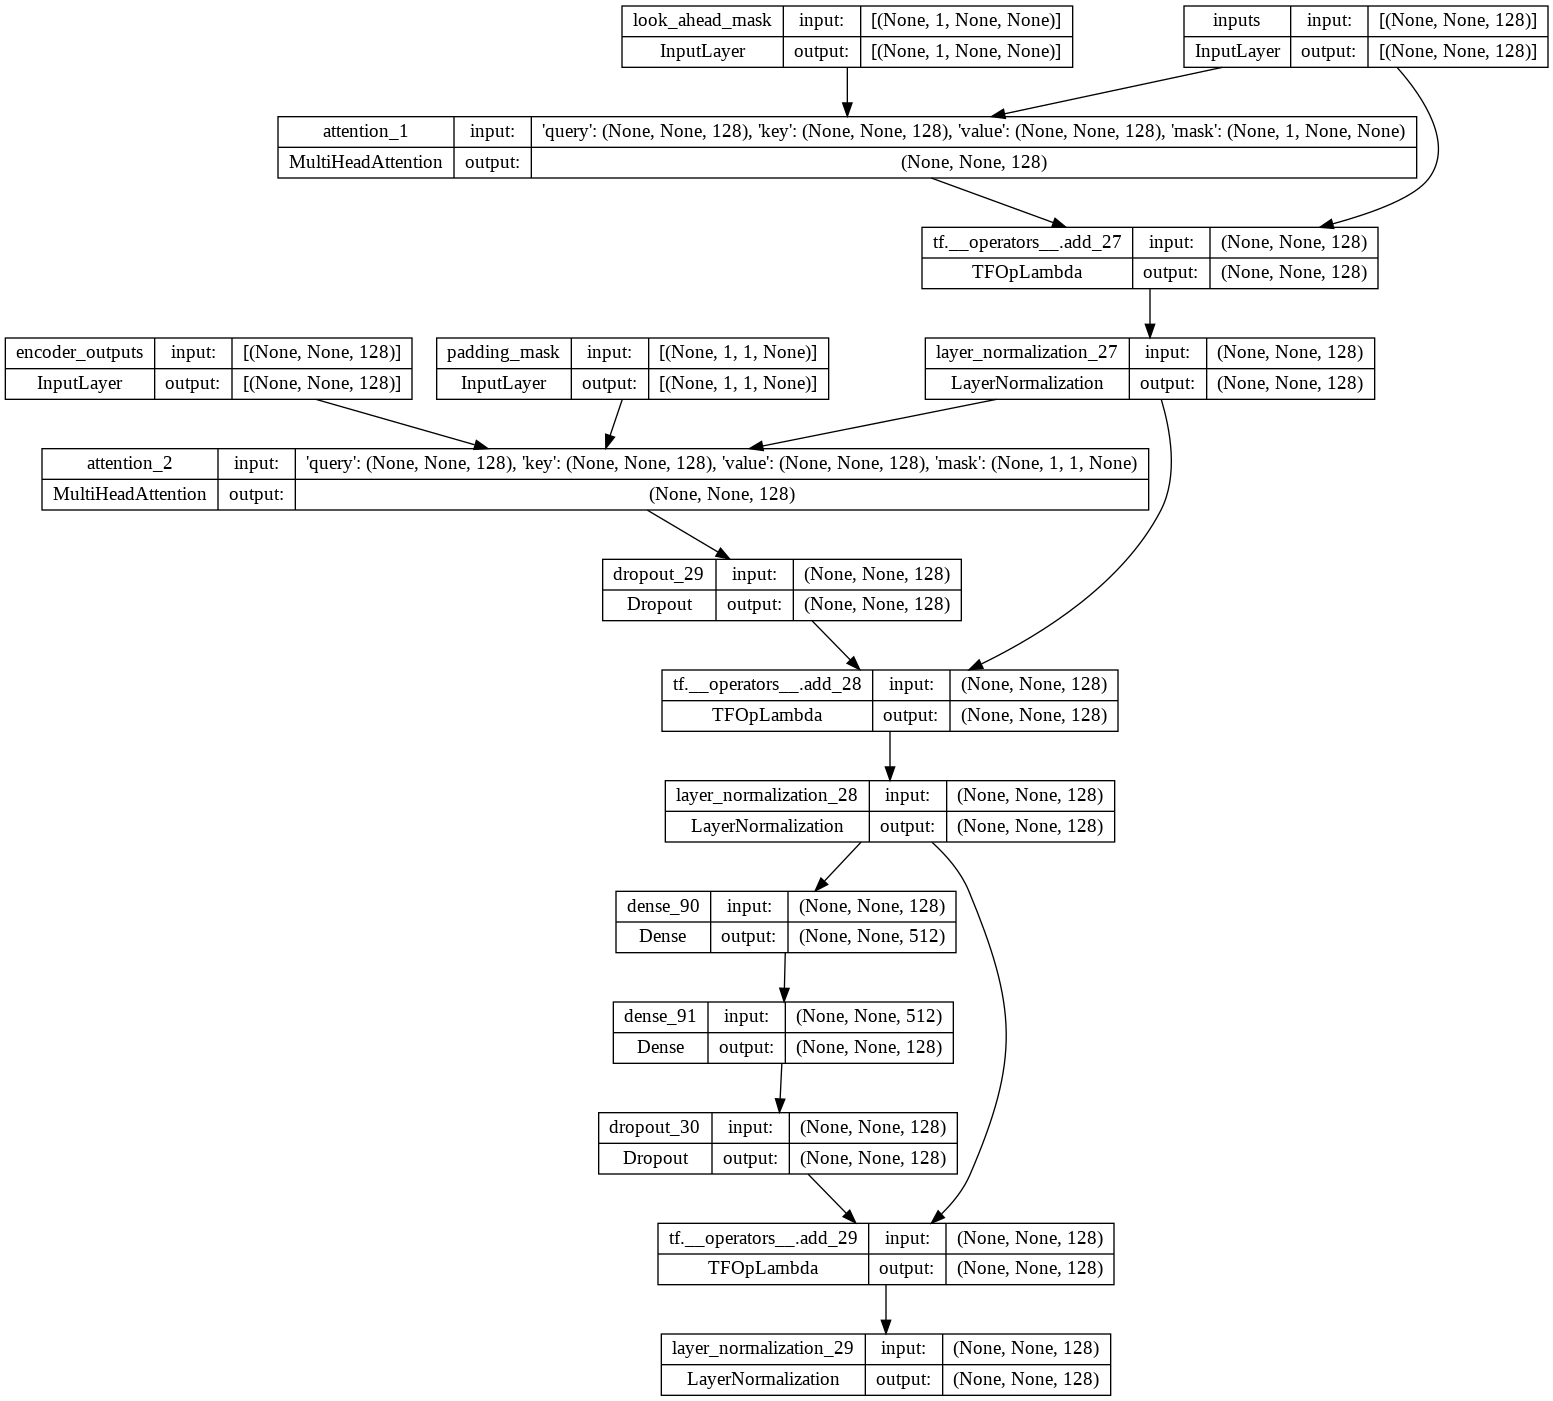

In [92]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

### Decoder


In [93]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

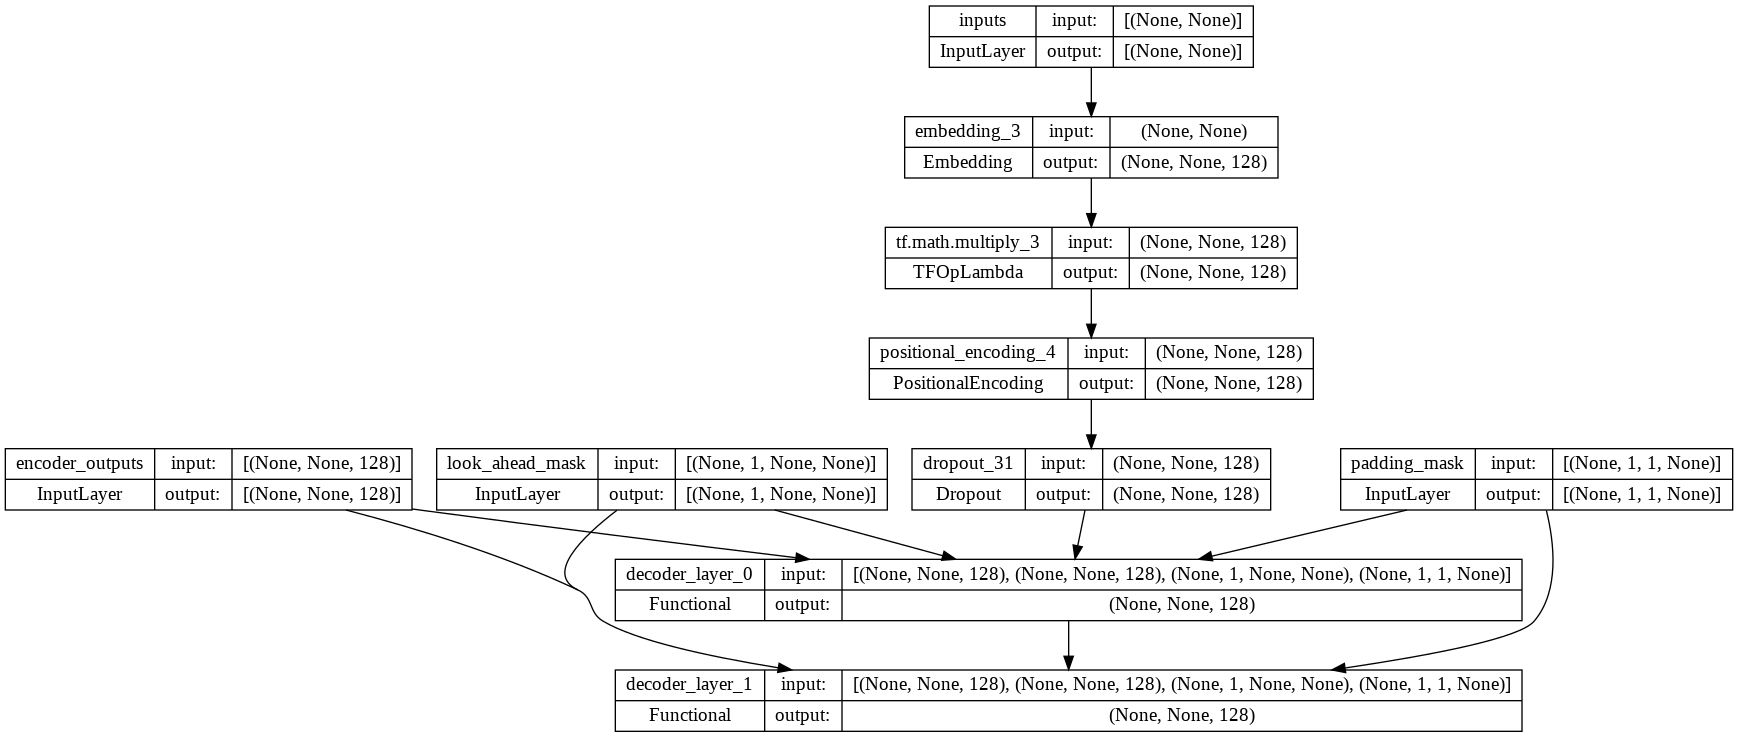

In [94]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

### Transformer

In [95]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

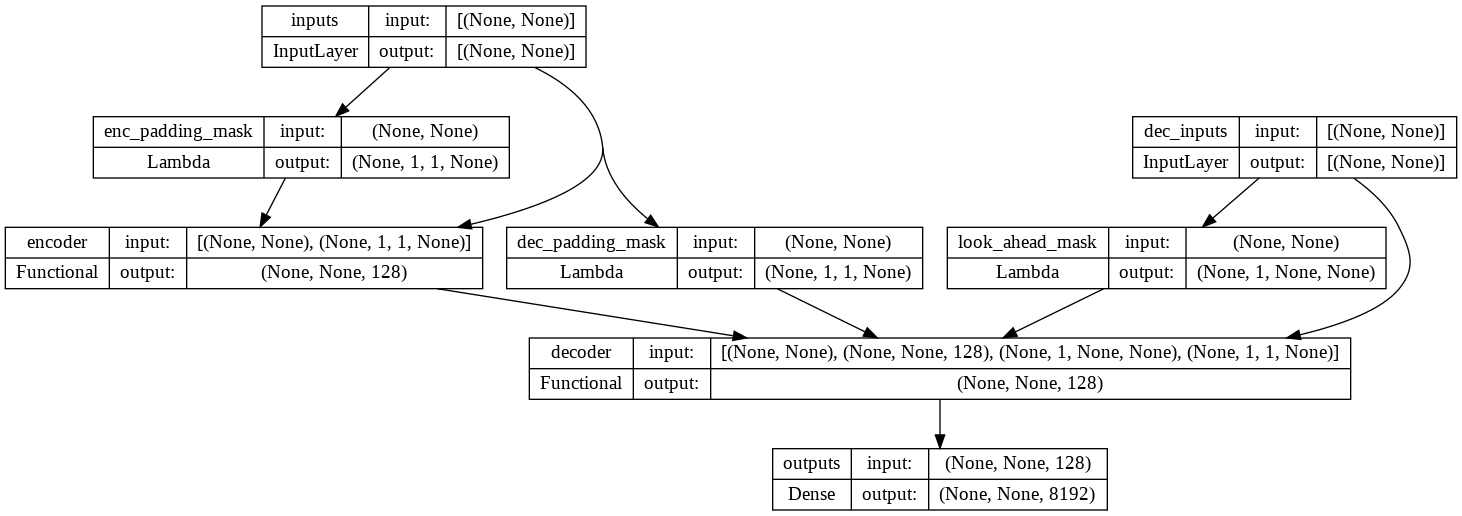

In [96]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

## Train model

### Initialize model

To keep this example small and relatively fast, the values for *num_layers, d_model, and units* have been reduced. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

In [97]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 1
D_MODEL = 64
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [98]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [133]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    # def get_config(self, d_model, warmup_steps):
    #     return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    # def from_config(cls, config):
    #     return cls(**config)

Text(0.5, 0, 'Train Step')

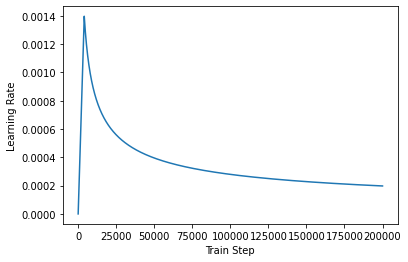

In [134]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Compile Model


In [137]:
#learning_rate = CustomSchedule(D_MODEL)
learning_rate = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### Fit model

Train our transformer by simply calling `model.fit()`

In [138]:
EPOCHS = 1

model.fit(dataset, epochs=EPOCHS)

704/704 [==============================] - 81s 115ms/step - loss: 1.2542 - accuracy: 0.0767


## Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`. 
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

In [139]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

Let's test our model!

In [140]:
# feed the model with its previous output
sentence = 'I like dinasours'
for _ in range(5):
  sentence = predict(sentence)
  print('')

Input: I like dinasours
Output: 

Input: 
Output: 

Input: 
Output: 

Input: 
Output: 

Input: 
Output: 



In [105]:
#model.save_weights('/content/drive/MyDrive/chatbot/chat_bot_weights.h5')

In [142]:
# Save the model
model.save('/content/saved_models/chatty', save_format='tf')

# Recreate the exact same model purely from the file
new_model = keras.models.load_model('/content/saved_models/chatty', 
                                    custom_objects={'loss_function':                   
                                                      loss_function})

In [143]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = new_model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence